## importing required libraries

In [10]:
# imported required libraries

# This module provides classes and functions for working with file system paths. 
import pathlib 
# TensorFlow provides tools for building and training machine learning models, including neural networks.
import tensorflow as tf
# numpy provides support for multidimensional arrays and various mathematical functions to operate on these arrays efficiently.
import numpy as np
# matplotlib commonly used for visualizing data and results.
import matplotlib.pyplot as plt

In [11]:
# here declare a class for visuailize, train and validate.
class CNN_model:

    # The __init__ method serves as the constructor for the class. It initializes attributes model, class_names, img_height, and img_width.
    def __init__(self):

        # self.model: This attribute is initialized to None and is presumably meant to store the trained CNN model.
        self.model = None

        # self.class_names: This is a list of class names representing the labels of the classification task (digits from 0 to 9).
        self.class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
        
        # self.img_height and self.img_width: These variables specify the height and width of the images expected by the model.
        self.img_height = 110
        self.img_width = 110

    # define a function for visualize. It takes two arguments: scores (a list of predicted scores) and path (a list of file paths of images).
    def __visuailize_data__(self, scores, path):
        
        # This part initializes variables columns and rows to specify the grid layout of subplots for visualizing images. 
        columns = 4
        rows = 5

        # Then, plt.subplots() creates a grid of subplots with the specified number of rows and columns, along with the figure size.
        fig, axes = plt.subplots(rows, columns, figsize=(7, 9))

        # This loop iterates over each subplot in the grid. For each subplot.
        for i in range(0, columns * rows):
            ax = axes.flat[i]
            # It sets the title to the predicted class label obtained from class_names.
            ax.set_title(str(int(config.class_names[np.argmax(scores[i])])))
            # It sets the ylabel to the predicted confidence score.
            ax.set_ylabel(str(int(100 * np.max(scores[i]))) + str("%"))
            # It removes the ticks from both x and y axes.
            ax.set_xticks([])
            ax.set_yticks([])
            # It reads and displays the corresponding image using plt.imread() and ax.imshow().
            image = plt.imread(path[i] + ".png")
            ax.imshow(image)

        # This line displays the figure containing the grid of subplots.
        plt.show()

    # define a function for prediction
    def get_prediction(self, path):
        
        # Two empty lists scores and rates are initialized. These lists will be used to store the predicted class and confidence scores for the image.
        scores = list()
        rates = list()

        # This line  specified by the file path path is loaded using tf.keras.preprocessing.image.load_img(). It is resized to the target dimensions specified by img_height and img_width.
        img = tf.keras.preprocessing.image.load_img(path, target_size=(self.img_height, self.img_width))
        
        # This line is converted into a numpy array using tf.keras.preprocessing.image.img_to_array() and then expanded to include an extra dimension representing the batch size using tf.expand_dims(). This is necessary because the model expects input in batch format.
        img_array = tf.expand_dims(tf.keras.preprocessing.image.img_to_array(img), 0)
        
        # The image array is passed through the model for prediction using self.model.predict(). The result is a probability distribution over the classes, which is passed through a softmax function using tf.nn.softmax() to obtain normalized probabilities.
        score = tf.nn.softmax(self.model.predict(img_array)[0])
        
        #The predicted class and confidence score are printed to the console.
        print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(
            self.class_names[np.argmax(score)], 100 * np.max(score)))
        
        # The predicted class and confidence score are appended to the scores and rates lists respectively.
        scores.append(self.class_names[np.argmax(score)])
        rates.append(100 * np.max(score))

        # The lists containing the predicted class and confidence score are returned as a tuple (scores, rates).
        return scores, rates

    # define a function for training
    def train_model(self):
        # define the batch size and dimensions (height and width) of the images.
        batch_size = 32
        img_height = 110
        img_width = 110

        # creates a Path object using the pathlib module, where the dataset is stored.
        data_dir = pathlib.Path("dataset/")

        # train_ds is created using image_dataset_from_directory() function from TensorFlow. It loads images from the directory specified by data_dir.
        train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir,
            validation_split=0.2,
            subset="training",
            seed=123,
            image_size=(img_height, img_width),
            batch_size=batch_size)

        # val_ds is created using image_dataset_from_directory() function from TensorFlow. It loads images from the directory specified by data_dir.
        val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir,
            validation_split=0.2,
            subset="validation",
            seed=123,
            image_size=(img_height, img_width),
            batch_size=batch_size)

        # This line retrieves the class names inferred from the dataset and prints them.
        class_names = train_ds.class_names
        print(class_names)

        # A normalization layer is created using Rescaling from TensorFlow. which scales pixel values from [0, 255] to [0, 1].
        normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255)
        normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
        image_batch, labels_batch = next(iter(normalized_ds))
        first_image = image_batch[0]

        # Notice the pixels values are now in `[0,1]`.
        print(np.min(first_image), np.max(first_image))

        # The constant AUTOTUNE is set to the value of tf.data.AUTOTUNE, which allows TensorFlow to automatically tune the number of CPU cores available for parallelism.
        AUTOTUNE = tf.data.AUTOTUNE

        # Both the training and validation datasets are cached and prefetched for better performance during training.
        train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
        val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

        # This line sets the number of classes in the classification task. In this case, there are 10 classes representing digits from 0 to 9.
        num_classes = 10

        # list_r containing a single learning rate value 0.03.
        list_r = [0.03]

        # This loop iterates over the learning rate values in the list_r.
        for r in list_r:

            # A sequential model is defined using tf.keras.Sequential(). The first layer applies rescaling to normalize pixel values to the range [0, 1].
            model = tf.keras.Sequential([
                tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),

                # Several convolutional layers with batch normalization and max-pooling are added to extract features from the input images.
                tf.keras.layers.Conv2D(16, kernel_size=3, padding='same', activation='relu', use_bias=True),
                tf.keras.layers.MaxPool2D(),
                tf.keras.layers.BatchNormalization(),

                # More convolutional layers are added for feature extraction.
                tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu', use_bias=True),
                tf.keras.layers.MaxPool2D(),

                # Additional convolutional layers with dropout are added to prevent overfitting.
                tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
                tf.keras.layers.MaxPool2D(2),
                tf.keras.layers.Dropout(0.3),

                # More convolutional layers with dropout and max-pooling are added to further extract features.
                tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
                tf.keras.layers.MaxPool2D(2),
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
                tf.keras.layers.MaxPool2D(2),

                # Flattening layer is added to convert the 2D feature maps into a 1D feature vector. Dense layers with dropout are added for classification, and the output layer with the number of classes and a bias term is added.
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(2048, activation='relu', use_bias=True),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(1024, activation='relu', use_bias=True),
                tf.keras.layers.Dense(num_classes, use_bias=True)
            ])

            # The model is compiled with stochastic gradient descent (SGD) optimizer with a specified learning rate and momentum, sparse categorical cross-entropy loss function, and accuracy metric.
            model.compile(
                optimizer=tf.keras.optimizers.SGD(learning_rate=r, momentum=0.7),
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

            # The model is trained using the fit() method on the training dataset (train_ds) with validation data (val_ds). Training proceeds for 85 epochs, and training history is stored in hist.
            hist = model.fit(
                train_ds,
                validation_data=val_ds,
                epochs=85,
                verbose=1,
            ).history

            # A summary of the model architecture is printed, showing the layers, output shape, and number of parameters.
            model.summary()
            self.model = model

            # Loss and accuracy curves for both training and validation data are plotted using Matplotlib.
            # this for loss. 
            plt.figure()
            plt.ylim([0, 5])
            plt.ylabel("Loss (training and validation)")
            plt.xlabel("Training Steps")

            # this for accuracy.
            plt.plot(hist["loss"])
            plt.plot(hist["val_loss"])
            plt.figure()
            plt.ylabel("Accuracy (training and validation)")
            plt.xlabel("Training Steps")
            plt.ylim([0, 1])
            plt.plot(hist["accuracy"])
            plt.plot(hist["val_accuracy"])

            # this for displays the plots.
            plt.show()
            

In [12]:
# call the CNN_model, model can be used to access the methods and attributes defined within the CNN_model class.
model = CNN_model()

Found 839 files belonging to 10 classes.


Using 672 files for training.
Found 839 files belonging to 10 classes.
Using 167 files for validation.
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
0.14901961 0.8980393
Epoch 1/85
21/21 [==============================] - 9s 321ms/step - loss: 2.3432 - accuracy: 0.1027 - val_loss: 2.3025 - val_accuracy: 0.0719
Epoch 2/85
21/21 [==============================] - 6s 281ms/step - loss: 2.3008 - accuracy: 0.1161 - val_loss: 2.3023 - val_accuracy: 0.1018
Epoch 3/85
21/21 [==============================] - 7s 316ms/step - loss: 2.2908 - accuracy: 0.1176 - val_loss: 2.3001 - val_accuracy: 0.1138
Epoch 4/85
21/21 [==============================] - 6s 296ms/step - loss: 2.2833 - accuracy: 0.1071 - val_loss: 2.2982 - val_accuracy: 0.1377
Epoch 5/85
21/21 [==============================] - 6s 269ms/step - loss: 2.2734 - accuracy: 0.1310 - val_loss: 2.2959 - val_accuracy: 0.1257
Epoch 6/85
21/21 [==============================] - 6s 267ms/step - loss: 2.2641 - accuracy: 0.1295 - val_loss: 2.2

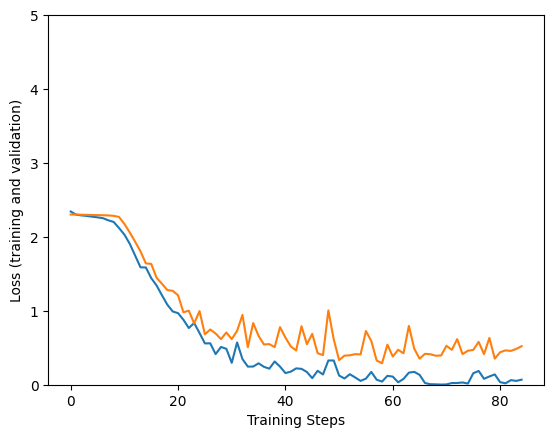

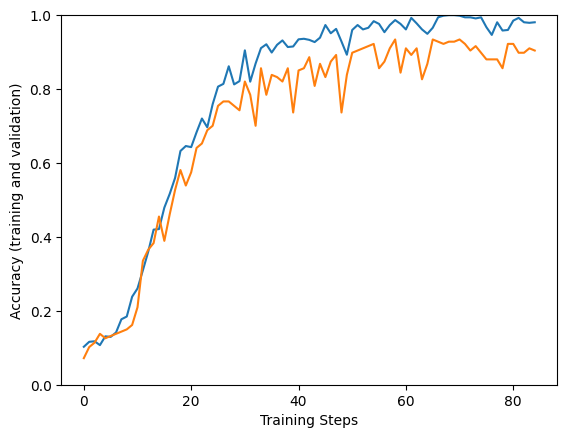

In [13]:
# calling the train_model
model.train_model()

In [14]:
# The line model.get_prediction("dataset/0/104.png") is calling the get_prediction() method of the model object, passing "dataset/0/104.png" as the argument path.
model.get_prediction("dataset/0/104.png")

1/1 [==============================] - 0s 236ms/step
This image most likely belongs to 0 with a 100.00 percent confidence.


(['0'], [100.0])

In [15]:
model.get_prediction("dataset/0/71.png")

1/1 [==============================] - 0s 42ms/step
This image most likely belongs to 0 with a 100.00 percent confidence.


(['0'], [100.0])

In [16]:
model.get_prediction("dataset/7/134.png")

1/1 [==============================] - 0s 54ms/step
This image most likely belongs to 7 with a 99.76 percent confidence.


(['7'], [99.75582361221313])

In [17]:
model.get_prediction("dataset/4/14.png")

1/1 [==============================] - 0s 56ms/step
This image most likely belongs to 4 with a 100.00 percent confidence.


(['4'], [99.99847412109375])